In [12]:
import pandas as pd
import numpy as np
csv = r"/home/deer8908/3rd Data WP/NaN_ex_3rd_excluded_GT2.csv"
csv = pd.read_csv(csv)

#입력 데이터 20행 부터 사용

/tmp/ipykernel_419472/786783504.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232) have mixed types. Specify dtype option on import or set low_memory=False.
  csv = pd.read_csv(csv)


1.Autoencoder 기반의 이상치 탐지의 경우 센서의 신뢰도에 의한 이상치를 탐지하는 것임.
2.추가 : NH3 슬립의 경우 이상치 탐지로 수행 가능한 방법이 있는가? [예측모델로 관련 데이터 입력 받아 예측 후 슬립 예측(징후가 있다면)]
3.비지도학습구간에는 이상치가 없다고 가정해야함.

1차 proto : NOx SCR INLET >> 301700 부근 이상치 의심  (CA 78열)

발전기 꺼질 때마다 NOx INLET 값 튐 >> 해당 부근 +-2천행 총 4천행 제외 및 해당 부분 보간 진행

이상치 구간 +-2천행 제외 후 보간
1. 44143(+- 2000)
2.130261
3.153763
4.219618
5.257458
6.287728
7.301840(이 부분이 발전기가 꺼져있는데 튀는 구간임) 현재 이 구간만 사용하여 AE 생성
8.475561

모델 : GAT - LSTM(Autoencoder) - Detector(예측 vs 실제 입력값 > anomaly score 계산 | Threshold 선정 = Precision-Recall 그래프 이용)





20        21.82
21        21.84
22        21.84
23        21.83
24        21.84
          ...  
561339    16.01
561340    15.86
561341    15.84
561342    15.85
561343    15.84
Name: PT.DCS.CC2-P.DCS.529502-13110-AE-FG001/PLOT, Length: 561324, dtype: object


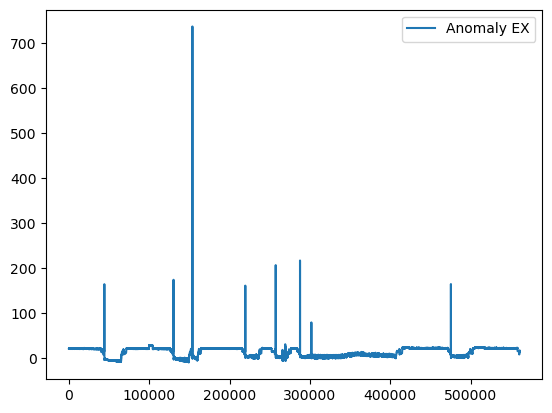

In [13]:
#이상치 제거하고 이어붙여서 AE 학습데이터 구섣 >> 전부 다 사용할것

target_col = csv.iloc[20:,78]

print(target_col)

target_col = pd.to_numeric(target_col)
import matplotlib.pyplot as plt

plt.plot(target_col, label = 'Anomaly EX')
plt.legend()
plt.show()

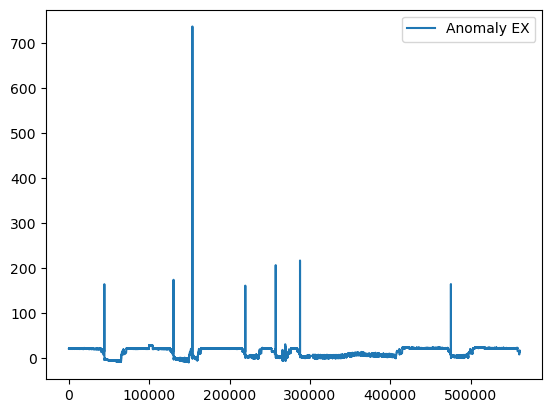

In [14]:
# 학습에 사용할 +- 2000행 짜리 / 299840 , 303840
target_col = target_col.drop(labels=range(299840,303840))
plt.clf()
plt.plot(target_col, label = 'Anomaly EX')
plt.legend()
plt.show()

input data
알파벳 한개씩 빼서 그래프 그릴것
22GT ACTLD (B = 2)
22GT EXHAUST GAS AVERAGE TEMPERATURE (EXHAUST) (BD=56)
22GT SPEED(AT = 46)
#2 HRSG SCR OUTLET TEMP + #2 HRSG SCR INLET TEMP ( OUT:DG = 111   IN:DE = 109)
#502 HRSG GAS  CASING TT (CK =  89)
#2 HRSG DUCT PRESS (DC = 107)

In [15]:
# 301840 이구간 +- 2000으로 데이터셋 구성

In [16]:
target_col = target_col.values.reshape(-1,1)
print(target_col.shape)

(557324, 1)


In [17]:
import torch
numbers = [2, 46, 56 , 111, 109,89 , 107]
numbers.sort()
print(numbers)


selected = csv.iloc[20:,numbers]
selected = selected.drop(labels=range(299840,303840))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler()
selected = scaler.fit_transform(selected)
target_col = scaler.fit_transform(target_col)

print(selected)

print('\n', target_col)
    

[2, 46, 56, 89, 107, 109, 111]
[[ 1.00416525 -1.25173386  0.70245263 ...  0.74240079  0.84138638
   0.579222  ]
 [ 1.0025031  -1.24335274  0.70202096 ...  0.74279616  0.841933
   0.58102703]
 [ 1.00084096 -1.22868577  0.7017188  ...  0.74269732  0.84211521
   0.58283206]
 ...
 [-0.49774925 -0.15310815 -0.41645797 ... -0.18938353  0.3427781
  -0.43339867]
 [-0.49874653 -0.15101287 -0.41658747 ... -0.19047079  0.34232258
  -0.43791124]
 [-0.49276281 -0.15124568 -0.41658747 ... -0.191904    0.3428692
  -0.43610621]]

 [[0.80219351]
 [0.80421281]
 [0.80421281]
 ...
 [0.19842134]
 [0.19943099]
 [0.19842134]]


In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [19]:
print(type(selected))
print("input Features:", selected)

train_value = torch.tensor(selected, dtype = torch.float32)

print(train_value.shape)

<class 'numpy.ndarray'>
input Features: [[ 1.00416525 -1.25173386  0.70245263 ...  0.74240079  0.84138638
   0.579222  ]
 [ 1.0025031  -1.24335274  0.70202096 ...  0.74279616  0.841933
   0.58102703]
 [ 1.00084096 -1.22868577  0.7017188  ...  0.74269732  0.84211521
   0.58283206]
 ...
 [-0.49774925 -0.15310815 -0.41645797 ... -0.18938353  0.3427781
  -0.43339867]
 [-0.49874653 -0.15101287 -0.41658747 ... -0.19047079  0.34232258
  -0.43791124]
 [-0.49276281 -0.15124568 -0.41658747 ... -0.191904    0.3428692
  -0.43610621]]
torch.Size([557324, 7])


In [20]:
print(selected.shape)
target_col = torch.tensor(target_col.values, dtype = torch.float32)
print(target_col.shape)

(557324, 7)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [10]:
def sliding_window(tensor , y_tensor,window_size , step):
    length,_ = tensor.shape
    length2 = len(y_tensor)
    
    if length != length2:
        print("Error: tensor length mismatch")
        return None
    else:
        num_windows = (length - window_size) // step + 1
        windows = []
        target_window=[]
        
        for i in range(num_windows):
            window = tensor[i*step: i*step + window_size,:]
            target_value = y_tensor[i*step + window_size - 1]
            windows.append(window)
            target_window.append(target_value.unsqueeze(0))
            
    return windows, target_window




In [13]:
train_window , y_window = sliding_window(train_value, target_col, 15 ,5)
print(len(train_window), len(y_window))

111462 111462


In [14]:
from torch.utils.data import Dataset, DataLoader



class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        return {'x' : x, 'y' : y}
    
       
    
dataset = CustomDataset(train_window, y_window)

dataloader = DataLoader(dataset, batch_size=32,shuffle=False)


         
        

In [25]:
for batch in dataloader:
    x_batch = batch['x']
    y_batch = batch['y']
    print("x batch:", len(x_batch))
    print("y batch:", len(y_batch))
    break

print(batch['x'].shape)

x batch: 32
y batch: 32
torch.Size([32, 15, 7])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


        